In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin


tkts = pd.read_csv('data/tickets.csv', index_col=0)['Ticket']
data = pd.read_csv('data/train.csv')
testdata = pd.read_csv('data/test.csv')

In [2]:
def tktno(x):
    try:
       return int(x.split()[-1])
    except ValueError:
        return 0
def tktype(x):
    tkt = x.split()
    tkt.pop()
    if len(tkt) != 0:
        return tkt[0]
    else:
        return '.'

ticketno = np.vectorize(tktno)
ticket_type = np.vectorize(tktype)

In [3]:
data['tkt'] = ticketno(data.Ticket)
data['Ticket'] = ticket_type(data.Ticket)

In [4]:
from functon_scripts.CustomEstimators import DoNothing, EmbarkedImputer, CabinImputer
from sklearn.compose import ColumnTransformer
from functon_scripts.col_names import clean_names

cols = data.columns.drop(['Cabin', 'Embarked'])
imputer_1 = ColumnTransformer([
    ('nthn', DoNothing(features=cols), cols),
    ('cabin_imp', CabinImputer(), ['Cabin']),
    ('Emb_imp', EmbarkedImputer(strategy='most_frequent'), ['Embarked'])
])

X = pd.DataFrame(imputer_1.fit_transform(data))
X.columns = clean_names(imputer_1.get_feature_names())
X.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,Z,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,Z,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,Z,S


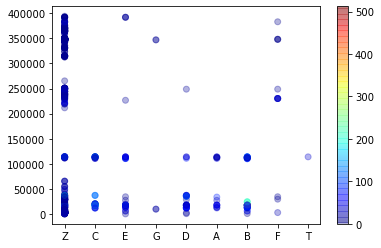

In [26]:
plt.scatter('Cabin', 'tkt', data=X[X.tkt < 3e6], c='Fare', cmap=plt.get_cmap('jet'), alpha=0.3)
plt.xticks(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z'])
plt.colorbar()

In [81]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(min_samples=2, eps=1, metric='l1')

In [82]:
X = data[~data.Embarked.isnull()][['Pclass', 'Embarked', 'tkt']]
from sklearn.compose import ColumnTransformer
from functon_scripts.CustomEstimators import DoNothing

pl = ColumnTransformer([
    ('nthn', DoNothing(features=['Pclass', 'tkt']), [0, 2]),
    ('ohe', OneHotEncoder(), [1])
])

X = pl.fit_transform(X)


In [83]:
dbs.fit(X)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='l1', metric_params=None,
       min_samples=2, n_jobs=None, p=None)

In [85]:
data1 = data[~data.Embarked.isnull()]
data1['cluster'] = dbs.labels_

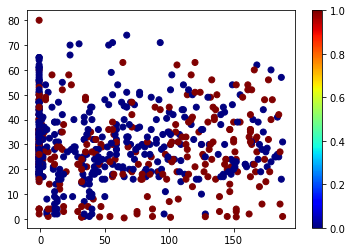

In [100]:
plt.scatter('cluster', 'Age', data=data1[data1.Fare < 200], c='Survived', cmap=plt.get_cmap('jet'))
plt.colorbar()

In [84]:
sum(dbs.labels_ == -1)

259

In [86]:
for i in range(-1, max(dbs.labels_)):
    n = sum(data1.cluster == i)
    if(n > 10):
        print(f'{i} => {n}')

-1 => 259
2 => 15
11 => 11
32 => 15
56 => 16


In [99]:
family_surname = np.vectorize(lambda x: x.split(',')[0])
len(np.unique(family_surname(testdata.Name)))

352

In [19]:
X.nthn__Ticket.unique()

array(['A/5', 'PC', 'STON/O2.', '.', 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'STON/O', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'A/4', 'WE/P',
       'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2', 'S.C./PARIS',
       'C.A./SOTON'], dtype=object)

In [20]:
X.columns

Index(['nthn__PassengerId', 'nthn__Survived', 'nthn__Pclass', 'nthn__Name',
       'nthn__Sex', 'nthn__Age', 'nthn__SibSp', 'nthn__Parch', 'nthn__Ticket',
       'nthn__Fare', 'nthn__tkt', 'cabin_imp__Cabin', 'Emb_imp__Embarked'],
      dtype='object')

In [2]:
class DiscreteFare(BaseEstimator, TransformerMixin):
    def __init__(self, bins=[-1, 5, 10, 35, 100, 250, np.inf]):
        self.bins = bins
    def fit(self, X=None, y=None):
        return self
    def transform(self, X):
        if not isinstance(X, pd.Series):
            X = pd.DataFrame(X).iloc[:, 0] 
        X = pd.cut(X, bins=self.bins, labels=np.arange(len(self.bins[:-1])))
        return X.to_numpy()

In [6]:
from sklearn.model_selection import c

In [5]:
import seaborn as sns
t = sns.load_dataset('tips')

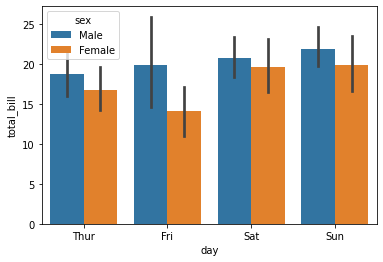

In [9]:
sns.barplot(x='day', y='total_bill', data=t, hue='sex')